In [1]:
import datetime
import pathlib

from utils import check_autocorr_ts
import pandas as pd

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from matplotlib import pyplot as plt

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
root_dir = pathlib.Path("../data")
dir_311 = root_dir/"311"/"2018"

df = pd.read_parquet(root_dir/"nypd"/"precincts")
df = df[df['created_H']>=datetime.date(2018,1,1)]
df

,borough,complaint_type,created_H,closed_H,created_date,closed_date,descriptor,status,resolution_description,resolution_action_updated_date,...,created_bo_ag,created_bo_co,open,open_bo,open_ag,open_co,open_bo_ag,open_bo_co,precinct,sector
24858,BROOKLYN,Traffic,2018-01-16 07:00:00,2018-01-16 11:00:00,2018-01-16 07:53:08,2018-01-16 11:07:21,Congestion/Gridlock,Closed,The Police Department responded to the complai...,2018-01-16 11:07:21,...,25,1,107899,30864,383,1,51,1,,
43904,BRONX,Derelict Vehicle,2018-01-27 13:00:00,2018-01-27 16:00:00,2018-01-27 13:20:24,2018-01-27 16:25:23,With License Plate,Closed,This complaint does not fall under the Police ...,2018-01-27 16:25:23,...,12,2,98111,21763,432,98,94,4,,
50792,BRONX,Derelict Vehicle,2018-01-31 07:00:00,2018-01-31 11:00:00,2018-01-31 07:53:07,2018-01-31 11:47:19,With License Plate,Closed,The Police Department responded to the complai...,2018-01-31 11:47:19,...,10,2,96487,21470,245,68,87,8,,
66268,BRONX,Derelict Vehicle,2018-02-09 20:00:00,2018-02-10 04:00:00,2018-02-09 20:37:21,2018-02-10 04:58:29,With License Plate,Closed,The Police Department responded to the complai...,2018-02-10 04:58:29,...,23,1,91431,19658,364,99,90,7,,
100312,BRONX,Derelict Vehicle,2018-03-01 12:00:00,2018-03-01 16:00:00,2018-03-01 12:38:59,2018-03-01 16:08:53,With License Plate,Closed,Your request can not be processed at this time...,2018-03-01 16:08:54,...,8,4,81968,16040,405,131,105,9,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750120,BROOKLYN,Noise - Street/Sidewalk,2018-12-30 22:00:00,2018-12-30 23:00:00,2018-12-30 22:32:22,2018-12-30 23:27:25,Loud Talking,Closed,The Police Department responded to the complai...,2018-12-30 23:27:25,...,53,3,96441,31402,819,68,103,4,94,094C
750676,BROOKLYN,Noise - Commercial,2018-12-31 04:00:00,2018-12-31 06:00:00,2018-12-31 04:20:29,2018-12-31 06:12:56,Banging/Pounding,Closed,The Police Department responded to the complai...,2018-12-31 06:12:56,...,7,1,95890,31119,670,19,67,4,94,094C
751615,BROOKLYN,Noise - Commercial,2018-12-31 18:00:00,2018-12-31 20:00:00,2018-12-31 18:50:20,2018-12-31 20:10:25,Loud Music/Party,Closed,The Police Department responded to the complai...,2018-12-31 20:10:25,...,28,1,94579,30276,736,17,69,4,94,094C
751868,BROOKLYN,Blocked Driveway,2018-12-31 21:00:00,2018-12-31 23:00:00,2018-12-31 21:24:26,2018-12-31 23:18:44,No Access,Closed,The Police Department responded and upon arriv...,2018-12-31 23:18:44,...,48,11,94636,30397,777,148,93,27,94,094C


In [ ]:
to_comp_df = df[['created_H', 'hours_to_complete']].groupby('created_H').mean().fillna(0)
target_bo_df = df[['created_H','borough', 'hours_to_complete']] \
        .groupby(['created_H','borough']) \
                .mean().unstack(['borough']).fillna(0)
target_pre_df = df[['created_H','sector', 'hours_to_complete']] \
        .groupby(['created_H','sector']) \
                .mean().unstack(['sector']).fillna(0)
target_sect_df = df[['created_H','precinct', 'hours_to_complete']] \
        .groupby(['created_H','precinct']) \
                .mean().unstack(['precinct']).fillna(0)

In [ ]:
to_comp_df.columns

In [ ]:
check_autocorr_ts(to_comp_df)

In [ ]:
check_autocorr_ts(target_bo_df,plots=False)

In [ ]:
check_autocorr_ts(target_pre_df, plots=False)


In [ ]:
check_autocorr_ts(target_sect_df, plots=False)

In [9]:
heirarchies = [
    ['borough'],
    [ 'borough','precinct'],
    [ 'borough','precinct', 'sector']
]

hdf = df[df['borough']!= 'Unspecified']
hdf = hdf[['created_H','hours_to_complete','borough','precinct', 'sector']]
hdf.rename({'created_H':'ds','hours_to_complete':'y'}, axis=1, inplace=True)
# hdf.rename({'hours_to_complete':'y'}, axis=1,inplace=True)


c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551:

TypeError: float() argument must be a string or a real number, not 'NAType'

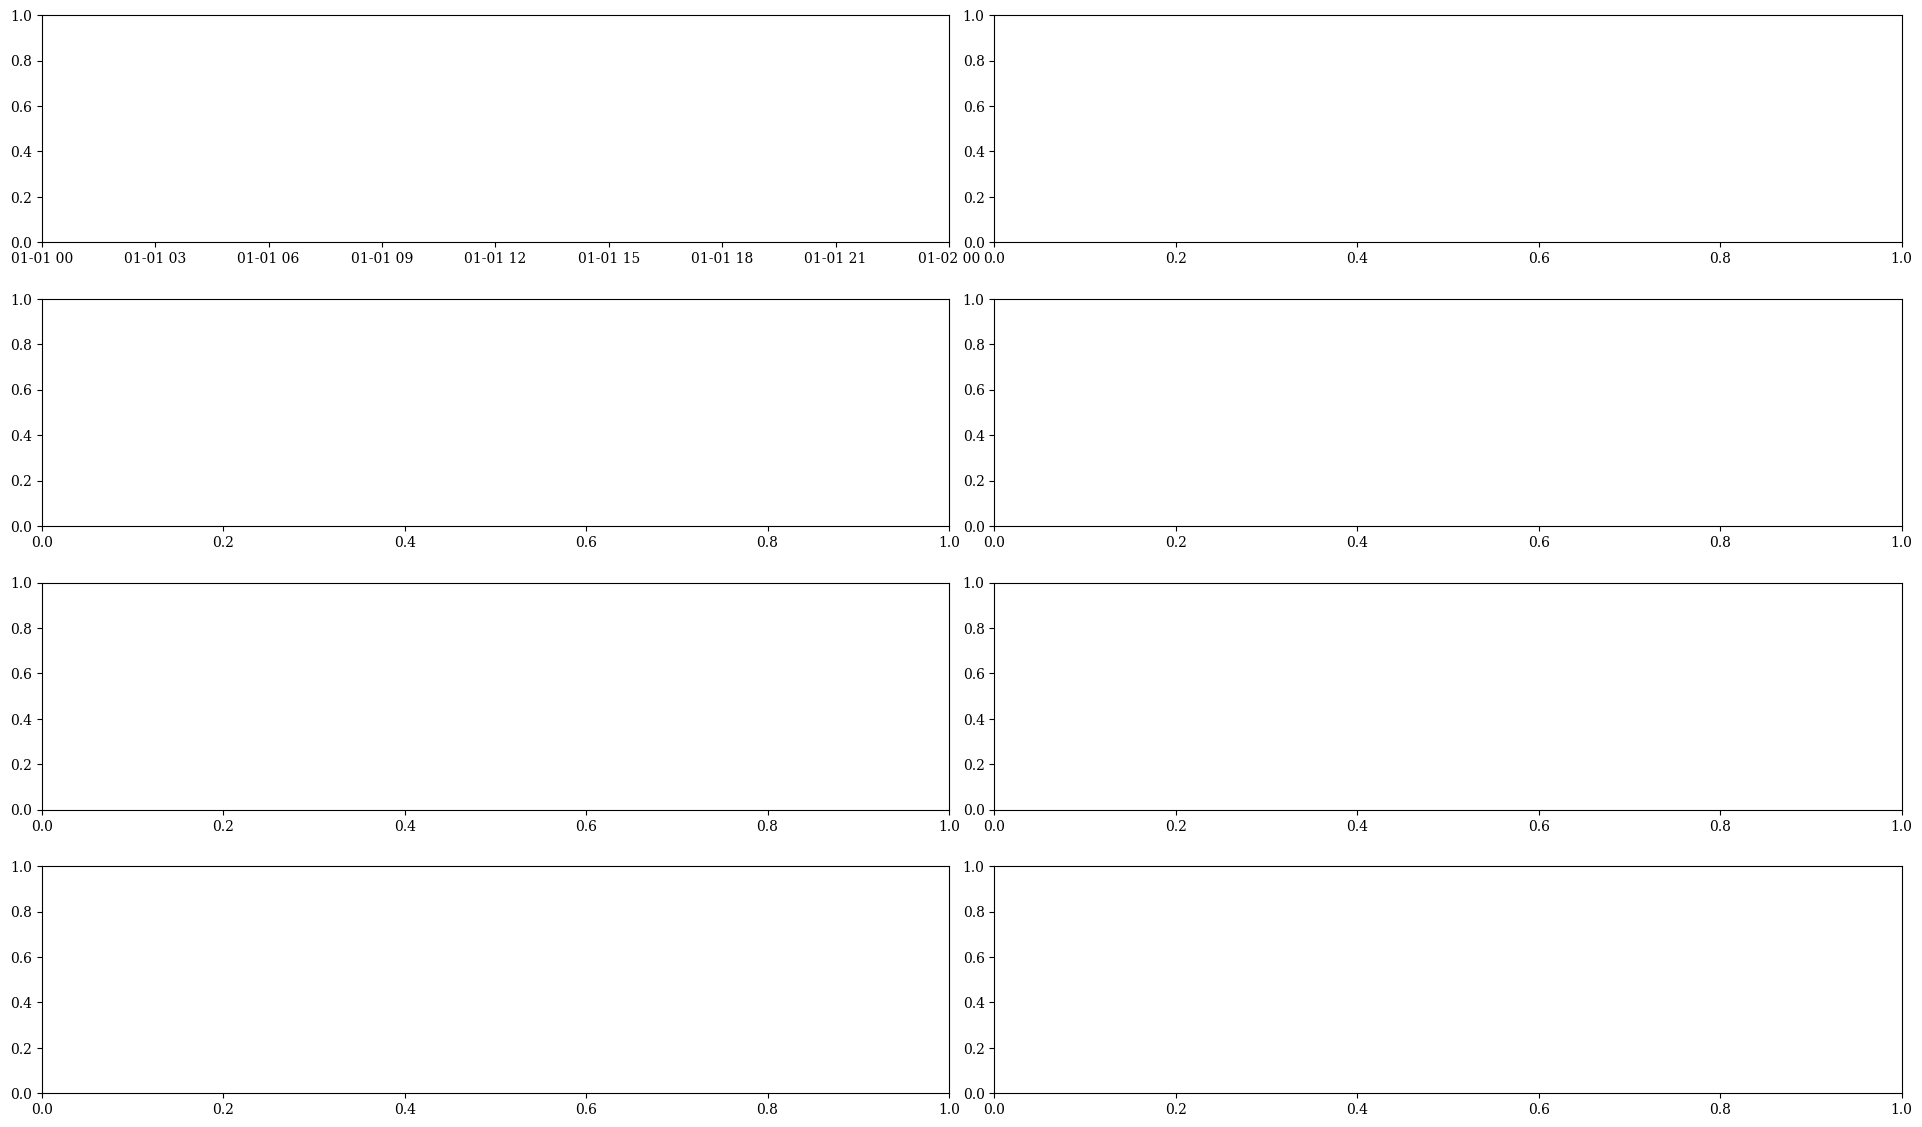

In [10]:
bdf, H_df, tags = aggregate(
    hdf,
    spec=heirarchies
)
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace('ols', nonnegative=True,num_threads=-1),
            ERM('closed'),
            # BottomUp()
        ]
)
Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1
    )
sf.fit()
fcts  = sf.forecast(h=1,df=bdf, level=[90])
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))

In [12]:
import joblib
joblib.dump(sf, '../models/hier_nypd_1.pkl')

['../models/hier_nypd_1.pkl']

In [13]:
fcts

,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
BRONX,2019-01-01 00:00:00,205.652679,-113.861732,525.167114
BRONX/,2018-09-11 23:00:00,4.925211,4.923921,4.926502
BRONX//,2018-09-11 23:00:00,4.925211,4.923921,4.926502
BRONX/114,2018-06-21 08:00:00,0.272500,0.272500,0.272500
BRONX/114/114B,2018-06-21 08:00:00,0.272500,0.272500,0.272500
...,...,...,...,...
STATEN ISLAND/122/122C,2019-01-01 00:00:00,3.556860,-4.425365,11.539085
STATEN ISLAND/123,2019-01-01 00:00:00,2.107156,-3.309224,7.523536
STATEN ISLAND/123/123A,2019-01-01 00:00:00,2.219243,-2.348019,6.786505


In [18]:
sf.save('../models/hier_nypd_1.model')

Saving StatsForecast object of size 37.36MB.
StatsForecast object saved
